In [ ]:
# 获取URL数据（北京地铁数据）：http://map.amap.com/service/subway?_1469083453978&srhdata=1100_drw_beijing.json

import requests
import re
import numpy as np
r = requests.get('http://map.amap.com/service/subway?_1469083453978&srhdata=1100_drw_beijing.json')
r.text

In [2]:
def get_lines_stations_info(text):
    '''
    根据爬取文本数据
    获取所有线路信息和所有站点信息
    
    Param
    ----------
    text : 文本信息
    
    Return
    ----------
    lines_info ： 所有线路信息的dict：key：线路名称；value：站点名称list
    stations_info ： 所有站点信息的dict：key：站点名称；value：站点坐标(x,y)
    
    '''
    lines_list = text.split("st")[1:]
    
    # 遍历text格式数据，组成地点数据结构
    # 所有线路信息的dict：key：线路名称；value：站点名称list
    lines_info = {}
    
    # 所有站点信息的dict：key：站点名称；value：站点坐标(x,y)
    stations_info = {}
        
    for i in range(len(lines_list)):
        
        # 站点名称 list
        stations = re.findall('\"n\":\"(\w+)\"', lines_list[i])
        # 站点坐标 list
        x_y = re.findall('\"sl\":\"(\d+.\d+),(\d+.\d+)\"', lines_list[i])
        x_y = [tuple(map(float, i)) for i in x_y]
        # 线路名称 
        sub_name = re.findall('\"ln\":\"(\w+)\"', lines_list[i])[0]
        
        lines_info[sub_name] = stations
        
        for i, k in dict(zip(stations, x_y)).items():
            stations_info[i] = k
    
    return lines_info, stations_info

lines_info, stations_info = get_lines_stations_info(r.text)

In [3]:
from collections import defaultdict

def get_neighbor_info(lines_info):
    '''
    根据线路信息，建立站点邻接表dict
    
    Param
    ----------
    lines_info ： 所有线路信息的dict：key：线路名称；value：站点名称list
    
    Return
    ----------
    neighbor_info ： 所有站点的邻接表
    
    '''
    neighbor_info = defaultdict(list)

    # 把str2加入str1站点的邻接表中
    def add_neighbor_dict(info, str1, str2):
        
        info[str1].append(str2)

    for sub_name, stations in lines_info.items():
        
        sta_len = len(stations)
        for i in range(sta_len -1):
            add_neighbor_dict(neighbor_info, stations[i], stations[i + 1])
            add_neighbor_dict(neighbor_info, stations[sta_len-1-i], stations[sta_len-2-i])

    return neighbor_info

neighbor_info = get_neighbor_info(lines_info)         

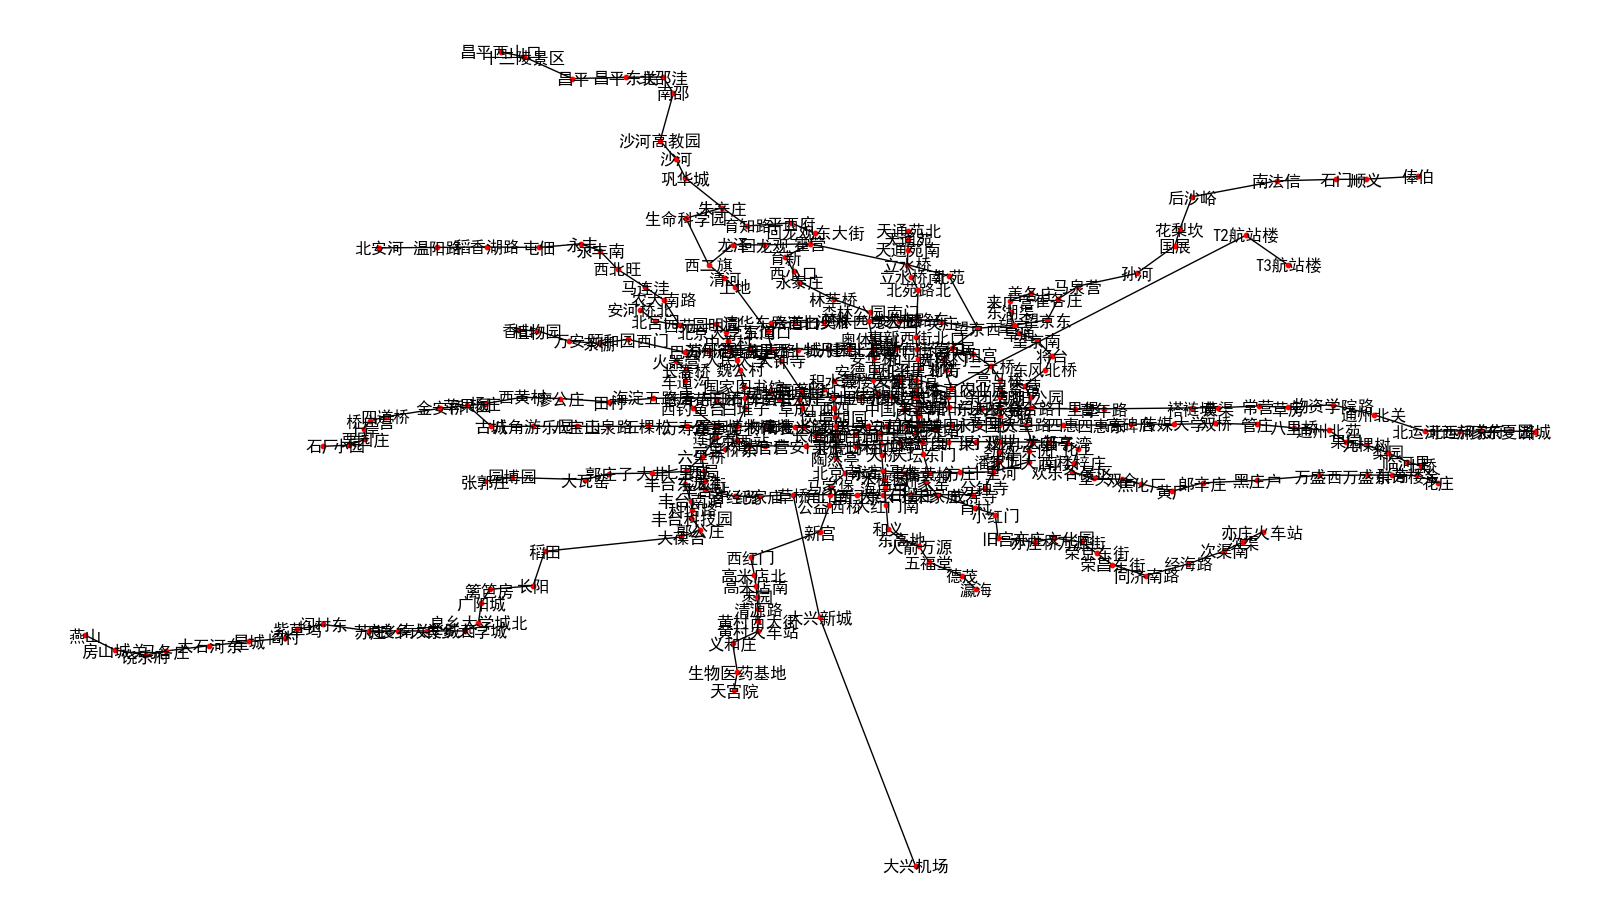

In [14]:
# 画地铁图
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt

# 如果汉字无法显示，请参照
matplotlib.rcParams['font.sans-serif'] = ['SimHei'] 
%matplotlib inline
plt.figure(figsize=(16, 9), dpi=100)

cities_connection_graph = nx.Graph(neighbor_info)
nx.draw(cities_connection_graph, stations_info, with_labels=True, node_size=10, node_color='red')

# 方法1：递归查找所有路径

In [5]:
def get_next_station_DFS_ALL(from_station, neighbor_info, to_station):
    '''
    递归算法，本质上是深度优先
    遍历所有路径
    这种情况下，站点间的坐标距离难以转化为可靠的启发函数，所以只用简单的BFS算法

    Param
    ----------
    neighbor_info : 邻接表
    from_station ： 起始站点
    to_station : 到达站点
    
    Return
    ----------
    new_path ： 起点到终点的路径
    
    '''
    
    pathes = [[from_station]]
    visited = set()
    
    while pathes:
        path = pathes.pop(0)
        node = path[-1]
        
        if node in visited: continue                    # 若已遍历，跳过 （图中是否为环）
        
        next_stas = neighbor_info[node]
        
        for next_sta in next_stas:
            if next_sta == path[-1]: continue           # 是否为前一个站点 
            
            new_path = path + [next_sta]
            if next_sta == to_station:
                return new_path
            
            pathes.append(new_path)
        visited.add(node)
                    
def station2sub(station):
    '''
    根据站点名称获取其所属的线路名称

    Param
    ----------
    station ： 站点名称
    
    Return
    ----------
    sub_list ： 所属线路列表（换乘站点或单站点）
    
    '''
    sub_list = []
    for sub_name, stations in lines_info.items():
        if station in stations:
            sub_list.append(sub_name)
    return sub_list


def result_text(path):
    '''
    根据搜索路径格式化输出出行路线提示信息
    
    Param
    ----------
    path ： 搜索路径
    
    Return
    ----------
    text ： 地铁出行路线提示信息
    
    '''
    
    # path中各个站点所属线路的list
    names_list = []
    
    # 遍历路径上的站点
    for index, station in enumerate(path[:-1]):
        
        name_list = station2sub(station)
        for name in name_list:
            if name in station2sub(path[index+1]):
                names_list.append(name)
           
        
    text = ""
    for index, name in enumerate(names_list):
        if index==0:
            text += f"{name}{path[0]}上车，"
        else:
            if name == names_list[index-1]: continue
            text += f"{path[index]}下车，换乘{name},"
            
    
    return text + path[-1] + "下车。" 


def get_path_DFS_ALL(from_station, to_station):

    path = get_next_station_DFS_ALL(from_station, neighbor_info, to_station)
    
    return result_text(path)
    

# 方法1  检查

In [6]:
%%time
get_path_DFS_ALL('亦庄火车站', '香山')

Wall time: 1.99 ms


'亦庄线亦庄火车站上车，宋家庄下车，换乘5号线,崇文门下车，换乘2号线,西直门下车，换乘13号线,知春路下车，换乘10号线,巴沟下车，换乘西郊线,香山下车。'

In [7]:
%%time
get_path_DFS_ALL('宋家庄', '牡丹园')

Wall time: 1.99 ms


'5号线宋家庄上车，东四下车，换乘6号线,南锣鼓巷下车，换乘8号线,北土城下车，换乘10号线,牡丹园下车。'

# 方法2：没有启发函数的简单宽度优先

In [8]:
def get_all_stations(from_station, neighbor_info, to_station, search_strategy=lambda x:x):
    '''
    根据不同搜索策略获取不同的最终路径
    
    Param
    ----------
    from_station ： 起始站点
    to_station ： 到达站点
    neighbor_info ：地铁线路各站点邻接图
    search_strategy ：搜索策略，默认无
    
    Return
    ----------
    new_path ： 所有路径
    
    '''    
    pathes = [[from_station]]
    visited = set()
    
    while pathes:

        path = pathes.pop(0)
        node = path[-1]
        
        if node in visited: continue                    # 若已遍历，跳过 （图中是否为环）
        
        next_stas = neighbor_info[node]
        
        for next_sta in next_stas:
            if next_sta == path[-1]: continue           # 是否为前一个站点 
            
            new_path = path + [next_sta]
            if next_sta == to_station:
                return new_path
            
            pathes.append(new_path)
            
        pathes = search_strategy(pathes)
        visited.add(node)
        
def get_path_BFS(from_station, to_station):
    '''
    搜索策略：以站点数量为cost（因为车票价格是按站算的）
    这种情况下，站点间的坐标距离难以转化为可靠的启发函数，所以只用简单的BFS算法
    由于每深一层就是cost加1，所以每层的cost都相同，算和不算没区别，所以省略
    检查输入站点名称
    
    '''
    
    def sort_by_stations_num(pathes):
        return sorted(pathes,key=lambda x:len(x))

    path = get_all_stations(from_station, neighbor_info, to_station, search_strategy=sort_by_stations_num)
    return result_text(path)


# 方法2 检查

In [9]:
%%time
get_path_BFS('亦庄火车站', '香山')

Wall time: 4.99 ms


'亦庄线亦庄火车站上车，宋家庄下车，换乘5号线,崇文门下车，换乘2号线,西直门下车，换乘13号线,知春路下车，换乘10号线,巴沟下车，换乘西郊线,香山下车。'

In [10]:
%%time
get_path_BFS('宋家庄', '牡丹园')

Wall time: 1.99 ms


'5号线宋家庄上车，东四下车，换乘6号线,南锣鼓巷下车，换乘8号线,北土城下车，换乘10号线,牡丹园下车。'

# 方法3 ： 以路径路程为cost的启发式搜索

In [11]:
import math

def get_path_Astar(from_station, to_station):
    '''
    搜索策略：以路径的站点间直线距离累加为cost，以当前站点到目标的直线距离为启发函数
    检查输入站点名称
    
    '''
    
    def sort_by_distance(pathes):

        def get_distance_of_path(path):

            distance = 0

            for i, station in enumerate(path[:-1]):
                x_y = stations_info[station]
                x_y_next = stations_info[path[i+1]]
                distance += math.hypot(x_y[0] - x_y_next[0], x_y[1] - x_y_next[1])

            return distance

        return sorted(pathes, key=get_distance_of_path)
    
    
    path = get_all_stations(from_station, neighbor_info, to_station, search_strategy=sort_by_distance)
    
    return result_text(path)


# 方法3 检查

In [12]:
%%time
get_path_Astar('亦庄火车站', '香山')

Wall time: 276 ms


'亦庄线亦庄火车站上车，宋家庄下车，换乘5号线,东四下车，换乘6号线,平安里下车，换乘4号线大兴线,西直门下车，换乘13号线,知春路下车，换乘10号线,巴沟下车，换乘西郊线,香山下车。'

In [13]:
%%time
get_path_Astar('宋家庄', '牡丹园')

Wall time: 62.9 ms


'5号线宋家庄上车，东四下车，换乘6号线,南锣鼓巷下车，换乘8号线,北土城下车，换乘10号线,牡丹园下车。'